<H1 align="center"> Análisis de Twitter con Python y Spark: <br> <br> Evento Julian Assange / Ciudad de Londres Inglaterra </center></H1> <br> <br><br> 

<center> Roque Leal </center> 
<center>DataScience en Marketing</center> <br> 

## ABSTRACT

<P1>Este Jupyter Notebook explora los conceptos de BigData y Consuming streaming Data para el análisis de las audiencias en redes sociales. Abordando estos conceptos se utilizan las herramientas de Apache Spark dentro del ambiente Python y consumiendo el Streaming API de Twitter a manera de conocer cuál es el comportamiento de la sociedad digital ante un evento especifico en una ciudad específica.<br> 
<br> En este caso se utilizará el evento de la detención del Sr. Julian Assange analizando específicamente la audiencia de la ciudad de Londres a manera de obtener resultados que inviten a dar una percepción de este evento y los indicadores claves de esta tendencia.<br>
<br>Resultados interesantes que otorgan una idea de las oportunidades que el análisis de los datos en Twitter brinda al momento de conocer y obtener métricas de la percepción de las audiencias; con potenciales usos para la activación de campañas, manejo de contenidos y pronosticar las interacciones posibles.
 </P1> <br> 


In [52]:
from pyspark import SparkContext, SparkConf

In [2]:
conf = SparkConf().setAppName('pyspark')

In [3]:
sc = SparkContext(conf=conf)

In [5]:
# General:
import sys
import tweepy           # para consumir el API de Twitter
import re
import math
import numpy as np
sc

<SparkContext master=local[*] appName=pyspark>

In [6]:
# para plotear y visualizar
from IPython.display import display
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import lit
from pyspark.sql import functions as func
from pyspark.sql.functions  import col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import bround
from pyspark.sql import Row
from dateutil import parser
from pyspark.sql.types import *

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [7]:
# twitter credenciales:
CONSUMER_KEY    = 'NGvWSELEqFhb8kzsgoyRrQ2iS'
CONSUMER_SECRET = 'efrfTopXB02DrQCAcuWwbC4ZFE0I6ObpwxhVbU1Rr60SEjBYho'

ACCESS_TOKEN  = '1062422137942761473-f1d8RY9zfC9BdzDYN5ag2lXf23vasw'
ACCESS_SECRET = 'PfjmJKUVbhUr59MhhPwebHXmGMRapoaHyaYh0MJoyvdT6'

In [8]:
def twitter():
    # Autentificarse
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Respuesta del API
    api = tweepy.API(auth)
    return api

In [9]:
spark = SparkSession(sc)

['ProtectJulian', 'Assange', 'Assange', 'Assange', 'hackers', 'ÚLTIMAHORA', 'WITNESS', 'JulianAssange', 'DonnieDementia', 'Assange', 'Equateur', 'USA', 'LeninMorenon', 'PAG', 'Assange', 'Sickening', 'Assange', 'Assange', 'EdwardSnowden', 'Assange', 'Snowden', 'Sweden']


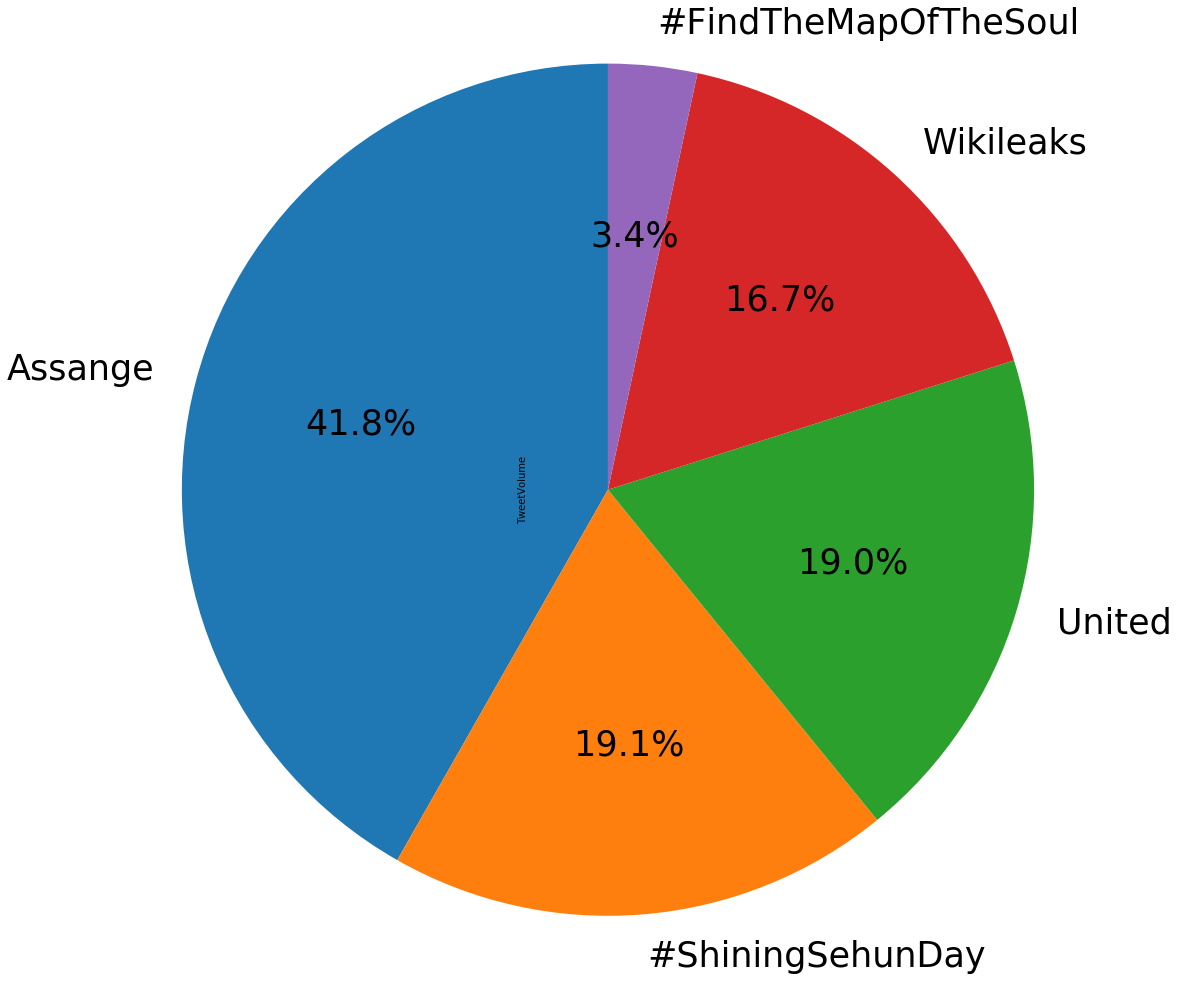

In [41]:
#Ingresar Ubicación basada en WOEID y encontrar los tweets mas populares
api = twitter()
tweet_pop = []
place = api.trends_place(id = 44418) #Londres
for location in place:
    for trend in location["trends"]:
        tweet_pop.append(trend["name"])
        tweet_pop.append(trend["tweet_volume"])

# Encuentra los 5 tweets mas populares basado en el volumen de trafico        
pop_list_tweet = [tweet_pop[2*i:2*i+2] for i in range(0,math.ceil(len(tweet_pop)/2))]
pop_list_tweet = spark.createDataFrame(pop_list_tweet, ["Tweet", "TweetVolume"])
pop_list_tweet = pop_list_tweet.withColumn("Tweet", pop_list_tweet["Tweet"].cast(StringType())).withColumn("TweetVolume", pop_list_tweet["TweetVolume"].cast(IntegerType()))
pop_list_tweet = pop_list_tweet.sort(desc("TweetVolume")).limit(5)
popular = pop_list_tweet.select(col("Tweet")).limit(1).collect()
res={}
for i in popular:
    res.update(i.asDict())
mostPopular= res['Tweet']
plt.title("Most Popular Tweets  ",fontsize = 40)
pop=pop_list_tweet.toPandas()
ax1 = plt.subplot(121, aspect='equal')
pop.plot(kind='pie', y = 'TweetVolume', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=pop['Tweet'], legend = False, fontsize= 35, radius=7)


#Busca los twees mas populares y grafica
tweets = api.search(q=mostPopular, count=1500)
lists = []
for tweet in tweets[:1500]:
    hashtags = tweet.entities.get('hashtags')
    for hashtag in hashtags:
            lists.append(hashtag['text'])
print(lists)

+--------------+
|      Hashtags|
+--------------+
| ProtectJulian|
|       Assange|
|       Assange|
|       Assange|
|       hackers|
|    ÚLTIMAHORA|
|       WITNESS|
| JulianAssange|
|DonnieDementia|
|       Assange|
|      Equateur|
|           USA|
|  LeninMorenon|
|           PAG|
|       Assange|
|     Sickening|
|       Assange|
|       Assange|
| EdwardSnowden|
|       Assange|
+--------------+
only showing top 20 rows



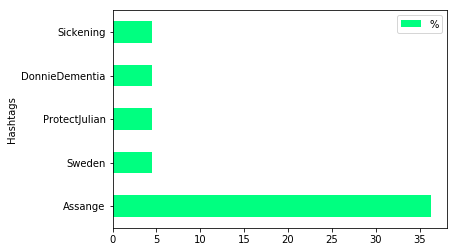

In [42]:
#hacer un top de los hashtags mas populares para los tweets mas frecuentes
rdd = sc.parallelize(lists)
new_row = Row("Hashtags")
df = rdd.map(new_row).toDF()
df.show()

#calcula su porcentaje 
from pyspark.sql.types import StructType
total=df.count()
result=(df.groupBy('Hashtags').count()
    .withColumn('Total',func.lit(total))
    .withColumn('Percentage',(col('count')/col('Total') *100))
    .withColumn('%',bround('Percentage',2))
    .sort(desc('%'))
    .limit(5)
    )

#plotear los hashtags mas populares
pdf1=result.toPandas()
pdf1.plot(kind='barh',x='Hashtags',y='%',colormap='winter_r')

In [43]:
#Detallar los tweets mas populares (Tweet, Retweet, Likes, y fecha de creacion)
list_tweet = []
for tweet in tweets:
    data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet.text).replace("\n","")
    list_tweet.append(data)
    list_tweet.append(tweet.retweet_count)
    list_tweet.append(tweet.favorite_count)
    list_tweet.append(str(parser.parse(str(tweet.created_at))))
list_tweet = [list_tweet[4*i:4*i+4] for i in range(0,math.ceil(len(list_tweet)/4))]
tweet_df = spark.createDataFrame(list_tweet, ["Tweet", "Retweet","Likes","Created_At"])
tweet_df = tweet_df.withColumn("Retweet", tweet_df["Retweet"].cast(IntegerType())).withColumn("Likes", tweet_df["Likes"].cast(IntegerType())).withColumn("Created_At", tweet_df["Created_At"].cast(DateType()))
tweet_df.show()

+--------------------+-------+-----+----------+
|               Tweet|Retweet|Likes|Created_At|
+--------------------+-------+-----+----------+
|RT @Lukewearechan...|     84|    0|2019-04-11|
|@wikileaks Freedo...|      0|    0|2019-04-11|
|RT @RamonFr773660...|     15|    0|2019-04-11|
|RT @wikileaks: As...|   2576|    0|2019-04-11|
|RT @jerome_corsi:...|    109|    0|2019-04-11|
|RT @Erramun2014: ...|    172|    0|2019-04-11|
|RT @Snowden: Juli...|   1880|    0|2019-04-11|
|RT @atrupar: As r...|    922|    0|2019-04-11|
|Julian Assange ex...|      0|    0|2019-04-11|
|RT @SethAbramson:...|    733|    0|2019-04-11|
|RT @Ruptly: BREAK...|   9569|    0|2019-04-11|
|RT @TwitterMoment...|   1738|    0|2019-04-11|
|Not sure what to ...|      0|    0|2019-04-11|
|RT @JordanCharito...|     17|    0|2019-04-11|
|RT @mitchellvii: ...|    128|    0|2019-04-11|
|RT @DDavidVillama...|     56|    0|2019-04-11|
|RT @ggreenwald: M...|    580|    0|2019-04-11|
|RT @nntaleb: Toda...|   1001|    0|2019

+--------------------+-------+
|               Tweet|Retweet|
+--------------------+-------+
|RT @MashiRafael: ...|  25964|
|RT @PrisonPlanet:...|  24602|
|RT @Ruptly: BREAK...|   9569|
|RT @wikileaks: As...|   4262|
|RT @Snowden: The ...|   4220|
+--------------------+-------+



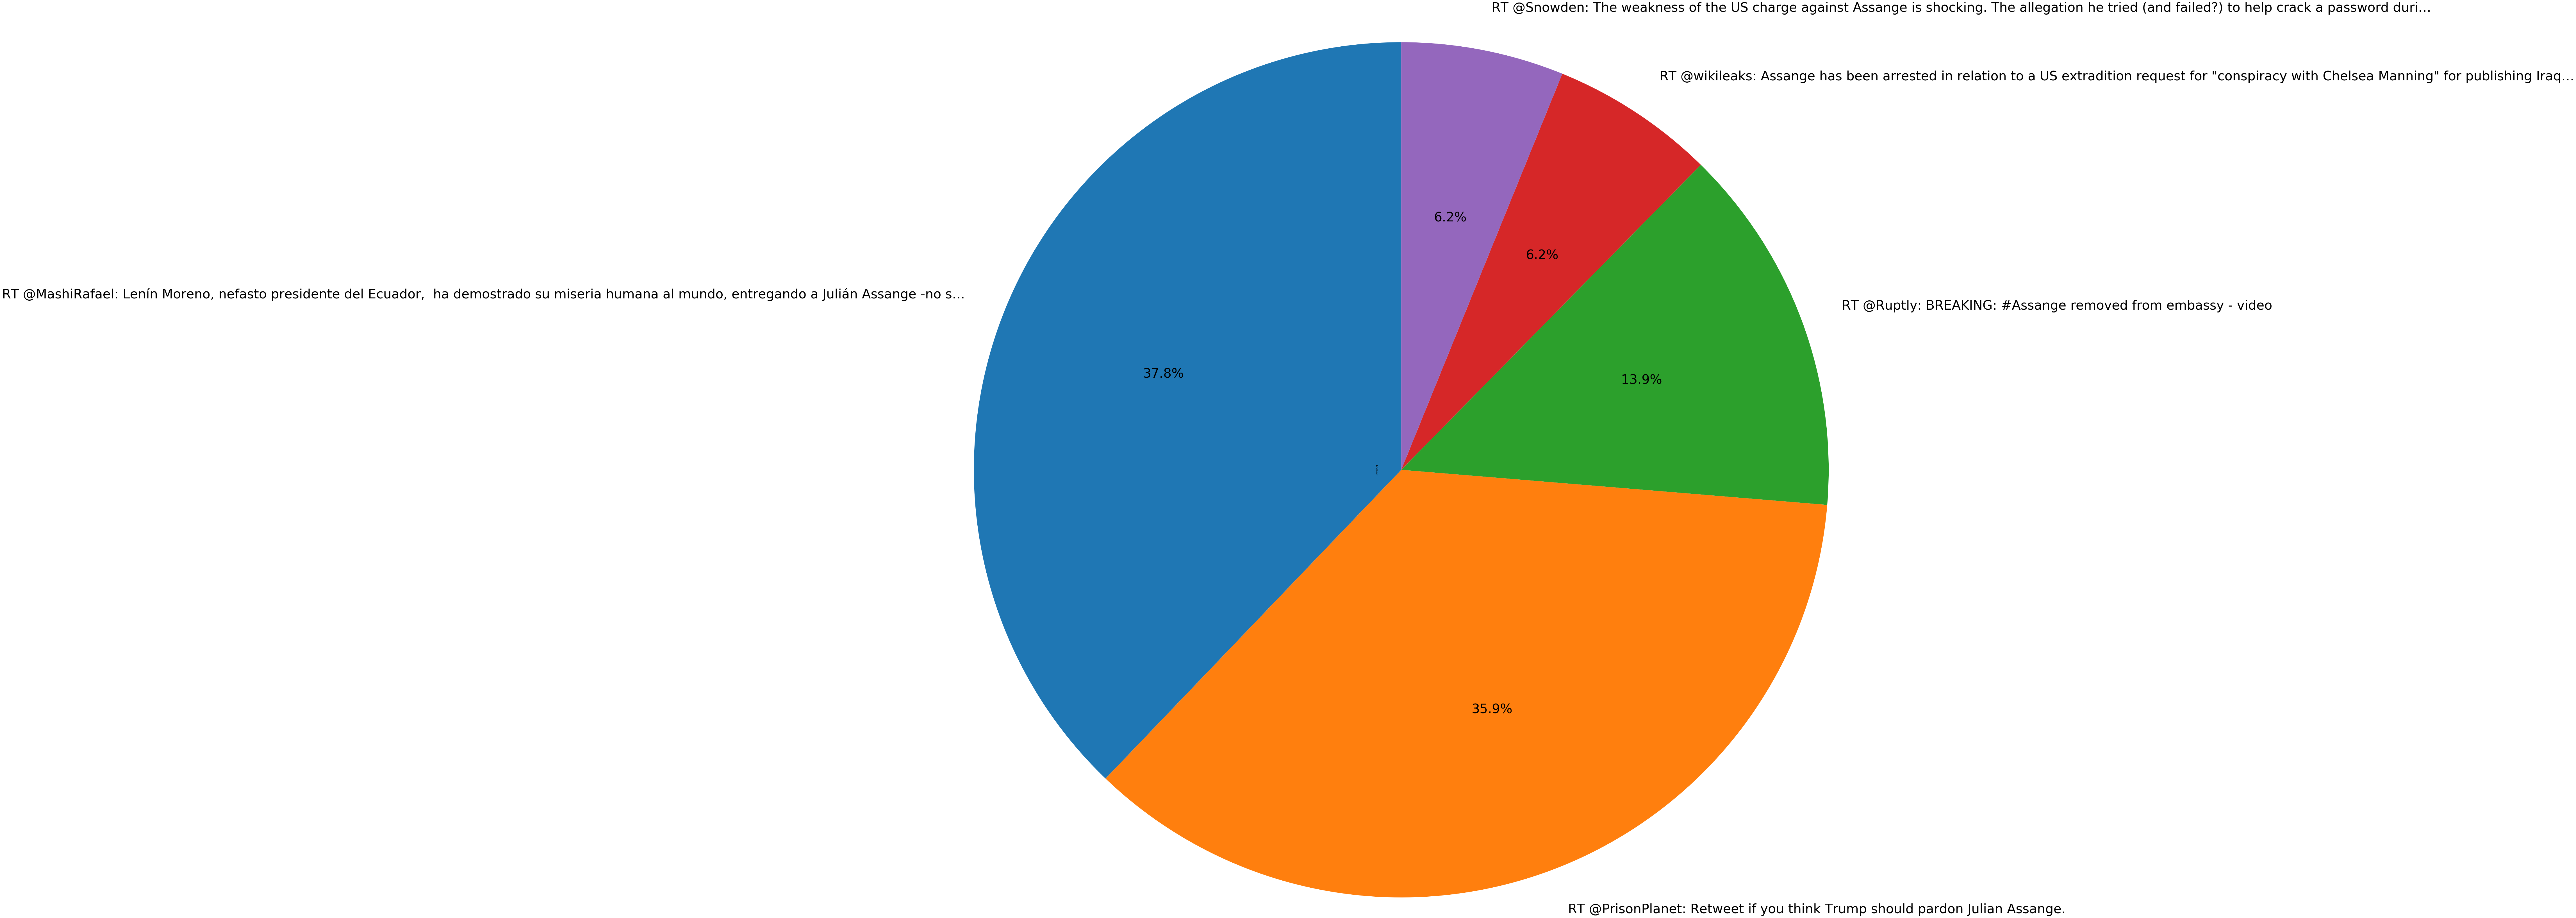

In [44]:
#Visualizar un top de los tweets mas retuiteados
max_retweet = tweet_df.groupBy('Tweet').agg(func.sum("Retweet").alias('Retweet'))
max_retweet = max_retweet.sort(desc('Retweet')).limit(5)
max_retweet.show()
plt.title("Most Retweeted Tweets on " + mostPopular,fontsize = 40)
pdf2=max_retweet.toPandas()
ax1 = plt.subplot(121, aspect='equal')
pdf2.plot(kind='pie', y = 'Retweet', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=pdf2['Tweet'], legend = False, fontsize= 46, radius=25)

In [45]:
#Visualizar la fecha de inicio de la tendencia
popular_month=(tweet_df.groupBy('Created_At').count())
mon_popular = popular_month.sort(desc('count')).show()

+----------+-----+
|Created_At|count|
+----------+-----+
|2019-04-11|   97|
+----------+-----+



In [46]:
#alimentar el análisis de sentimiento con palabras positivas y negativas
pos = []
with open( r'positive.txt' , encoding = "ISO-8859-1") as file1:
    for line in file1: 
        line = line.strip().lower() 
        pos.append(line)

#negative words for sentimental analysis
neg = []
with open(r'negative.txt' , encoding = "ISO-8859-1") as file2:
    for line in file2: 
        line = line.strip().lower()
        neg.append(line)

In [47]:
from pyspark.sql import SQLContext

In [48]:
sqlContext = SQLContext(sc)

59
26


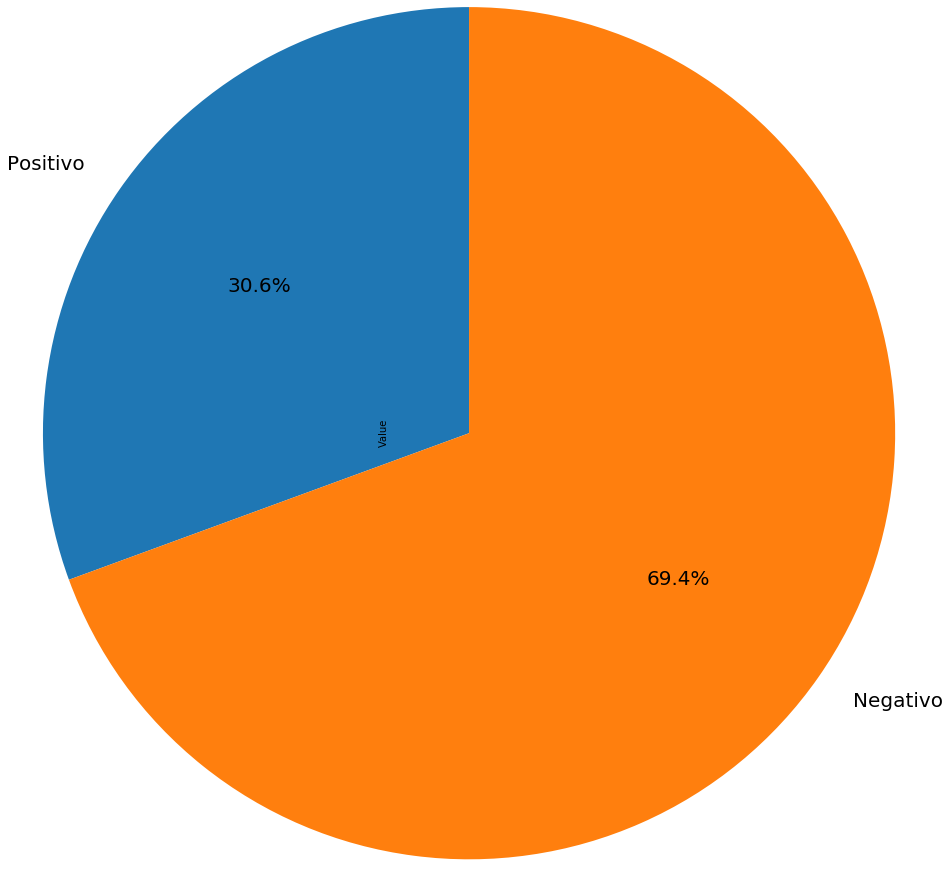

In [61]:
#use los listados para ser comparados en un análisis de sentimientos
#encuentre sentimientos negativos y positivos acerca del tendencia 
newlist = []
for tweet in tweets:
    data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet.text)
    data =  re.findall(r'\w+', data.lower())
    newlist.append(data)
words = sc.parallelize(newlist)
words.take(100)
words_neg = words.map(lambda x : (x,1) if [i for i in x if i in neg] else (x,0))
words_pos = words.map(lambda x : (x,1) if [i for i in x if i in pos] else (x,0)) 
neg_percent = words_neg.map(lambda x :x[1]).collect()
neg_percent = (sum(neg_percent))
print(neg_percent)
pos_percent = words_pos.map(lambda x :x[1]).collect()
pos_percent = (sum(pos_percent))
print(pos_percent)


#plotear un porcentaje de los sentimentos 
from pyspark.sql import Row
l = [('Positivo',pos_percent),('Negativo',neg_percent)]
rdd = sc.parallelize(l)
sentiment = rdd.map(lambda x: Row(Sentiments=x[0], Value=int(x[1])))
sentiment = sqlContext.createDataFrame(sentiment)
pie=sentiment.toPandas()
plt.title(" Sentimental Analysis On " +mostPopular,fontsize = 20)
ax1 = plt.subplot(121, aspect='equal')
pie.plot(kind='pie', y = 'Value', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=pie['Sentiments'], legend = False,fontsize= 20, radius=7)

+--------------------+--------+
|               Tweet|      SA|
+--------------------+--------+
|RT    Wikileaks A...|Negativo|
|  Freedom to Juli...|Negativo|
|RT    Does Julian...|Negativo|
|RT    Assange arr...| Neutral|
|RT   corsi  Here ...|Negativo|
|RT    Nunca podre...|Negativo|
|RT    Julian Assa...|Negativo|
|RT    As rumors o...|Negativo|
|Julian Assange ex...| Neutral|
|RT    Today is th...|Positivo|
|RT    BREAKING   ...|Negativo|
|RT    Wikileaks f...|Negativo|
|Not sure what to ...|Positivo|
|RT    TO BE CLEAR...| Neutral|
|RT    This charge...|Negativo|
|RT    There is a ...|Negativo|
|RT    Many corpor...| Neutral|
|RT    Today  they...|Negativo|
|RT    No  Democra...|Negativo|
|RT     Qu  verg e...|Negativo|
+--------------------+--------+
only showing top 20 rows

+--------+-----+
|      SA|count|
+--------+-----+
|Negativo|   56|
| Neutral|   18|
|Positivo|   23|
+--------+-----+



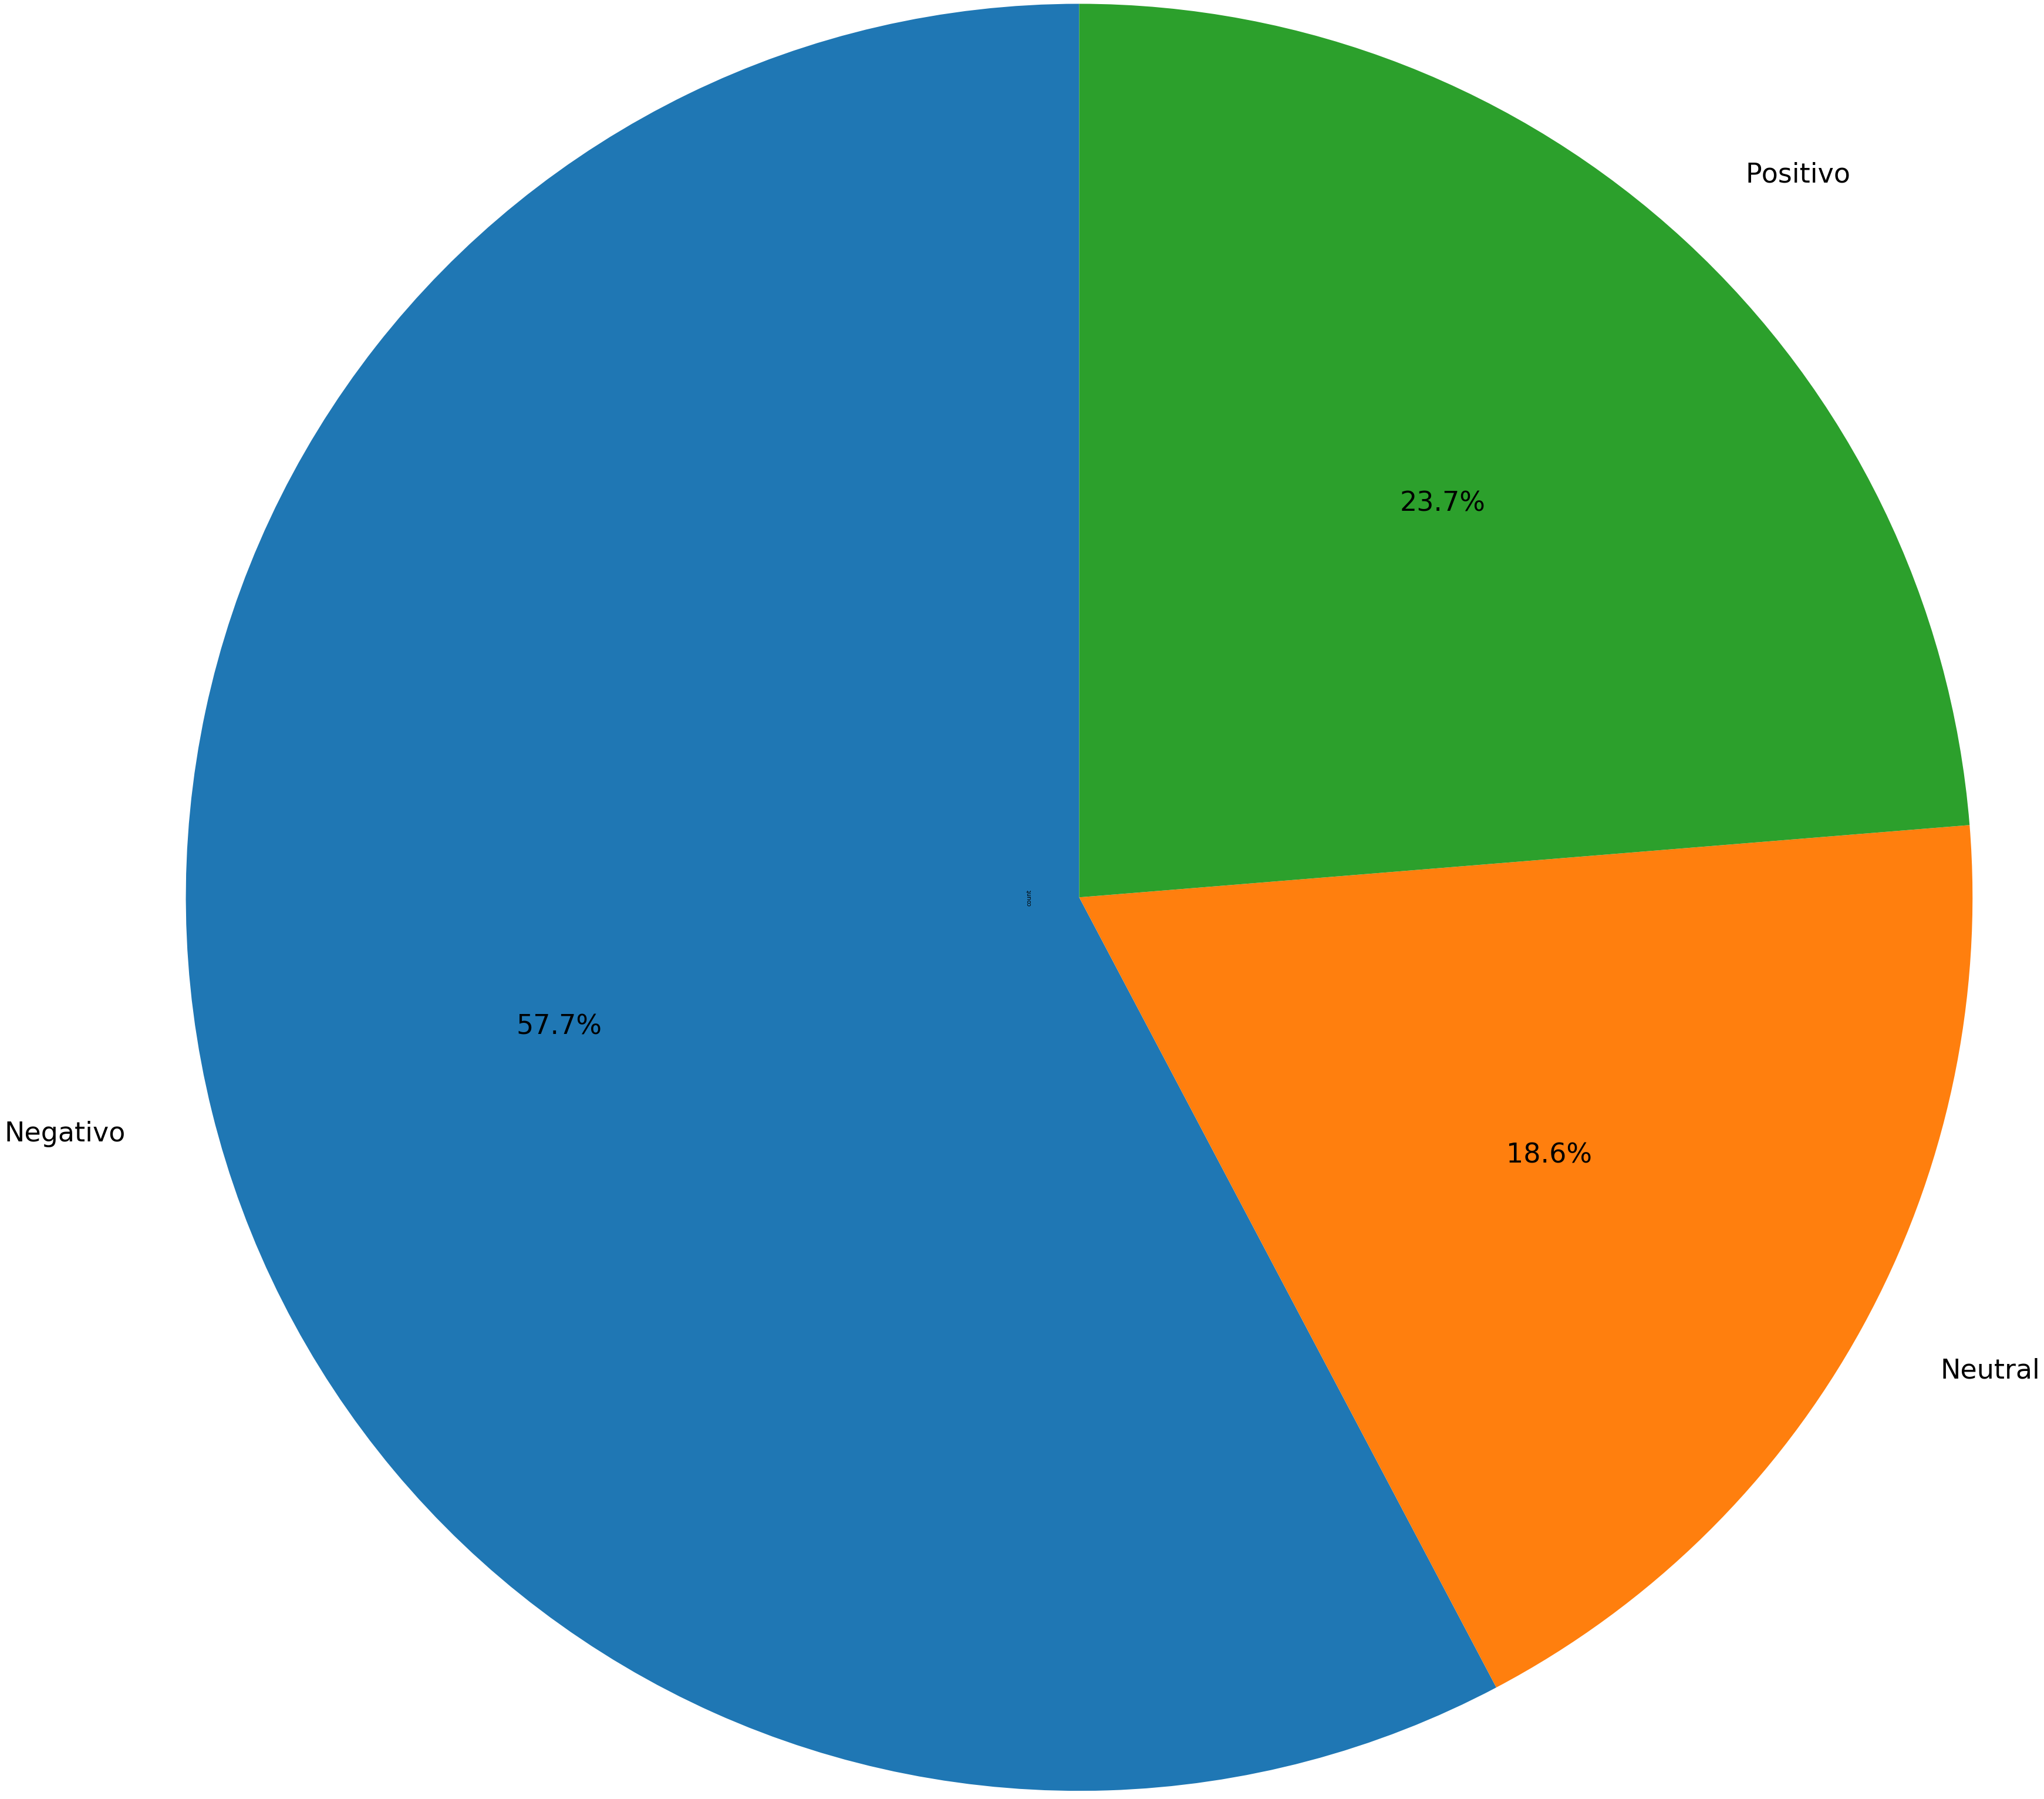

In [50]:
#Hacer un analisis de sentimiento usando Textblob
from textblob import TextBlob
import re
txtblb=[]
for tweet in tweets:
    data = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.text)
    txtblb.append(data) 
    analysis = TextBlob(data)
    if analysis.sentiment.polarity > 0:
        txtblb.append('Positivo') 
    elif analysis.sentiment.polarity == 0:
        txtblb.append('Negativo')
    else:
        txtblb.append('Neutral')
sent_tweet = [txtblb[2*i:2*i+2] for i in range(0,math.ceil(len(txtblb)/2))]
sent_tweet = spark.createDataFrame(sent_tweet, ["Tweet", "SA"])
sent_tweet = sent_tweet.withColumn("Tweet", sent_tweet["Tweet"].cast(StringType())).withColumn("SA", sent_tweet["SA"].cast(StringType()))
sent_tweet.show()
sent_tweet = (sent_tweet.groupBy('SA').count())
sent_tweet.show()
sent_tweet_pdf=sent_tweet.toPandas()
ax1 = plt.subplot(121, aspect='equal')
sent_tweet_pdf.plot(kind='pie', y = 'count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=sent_tweet_pdf['SA'], legend = False, fontsize= 46, radius=25)